# Importing Libraries

In [ ]:
import torch
import torch . nn as nn
import torch . optim as optim
from torch . utils . data import DataLoader
import torchvision . transforms as transforms
import torchvision . datasets as datasets

# Load Dataset and Create Dataloaders

In [ ]:
import torch
from torchvision import datasets, transforms

In [ ]:
transform = transforms . Compose ([
    transforms . ToTensor () ,
    transforms . Normalize ((0.5 ,) , (0.5 ,) )
    ])
train_dataset = datasets.MNIST ( root ='./ data ', train = True , transform =
  transform , download = True )
test_dataset = datasets.MNIST ( root ='./ data ', train = False , transform =
  transform )

train_loader = DataLoader ( train_dataset , batch_size = batch_size , shuffle =
  True )
test_loader = DataLoader ( test_dataset , batch_size = batch_size , shuffle =
  False )


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.15MB/s]


====================================

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=1d78dbd64edd6c230c89872d5aa98ea86de5f31de373245e294ec28f1192976a
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


# **CNN-LSTM MODEL FOR FEATURE EXTRACTION**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from minisom import MiniSom
import numpy as np
from tqdm import tqdm
from sklearn.metrics import normalized_mutual_info_score as nmi_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN-LSTM Model
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        # CNN for spatial features
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # [B, 32, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # [B, 32, 14, 14]
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # [B, 64, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # [B, 64, 7, 7]
        )
        # LSTM for sequential features (treat image rows as sequences)
        self.lstm = nn.LSTM(
            input_size=64 * 7,  # Each row has 7 pixels (after pooling)
            hidden_size=128,
            num_layers=1,
            batch_first=True
        )


        # Feature projector
        self.fc = nn.Linear(128, 64)  # Final feature dimension
        # New decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.Linear(128, 64*7*7),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # CNN
        x = self.cnn(x)  # [B, 64, 7, 7]
        B, C, H, W = x.shape
        # Reshape for LSTM: [B, H, C*W] (treat each row as a sequence)
        x = x.permute(0, 2, 1, 3).reshape(B, H, C * W)  # [B, 7, 64*7]
        # LSTM
        _, (h_n, _) = self.lstm(x)  # h_n: [1, B, 128]
        features = h_n.squeeze(0)    # [B, 128]
        # Project to lower dimension
        features = self.fc(features) # [B, 64]
        return features

In [ ]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,}")
    return total, trainable

# Instantiate and count
model = CNNLSTM().to(device)
count_parameters(model)


Total parameters: 754,625
Trainable parameters: 754,625


(754625, 754625)

# SOM Clustering with 10 epochs

Training CNN-LSTM...


Epoch 10/10: 100%|██████████| 235/235 [00:12<00:00, 18.73it/s]


Extracting features...


100%|██████████| 235/235 [00:12<00:00, 18.40it/s]


Clustering with SOM...
Clustering NMI: 0.0644


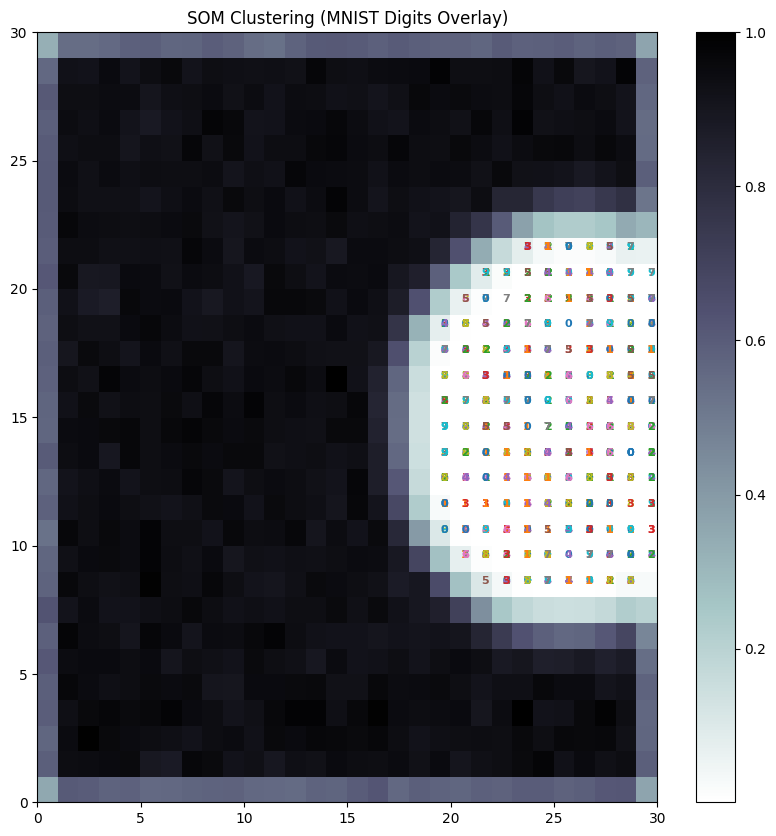

In [ ]:
def train_and_cluster():
    # Load MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

    # Initialize model and optimizer
    model = CNNLSTM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Step 1: Train CNN-LSTM (unsupervised)
    print("Training CNN-LSTM...")
    model.train()
    for epoch in range(10):
        for batch, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/10"):
            batch = batch.to(device)
            optimizer.zero_grad()
            features = model(batch)
            loss = torch.mean(features.pow(2)) * 0.01   # Add a decoder network


            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()


    # Step 2: Extract features
    print("Extracting features...")
    model.eval()
    features = []
    true_labels = []
    with torch.no_grad():
        for batch, labels in tqdm(train_loader):
            batch = batch.to(device)
            feats = model(batch)
            features.append(feats.cpu().numpy())
            true_labels.append(labels.numpy())
    features = np.concatenate(features)
    true_labels = np.concatenate(true_labels)

    # Step 3: Train SOM
    print("Clustering with SOM...")
    som = MiniSom(
        x=30, y=30,          # 10x10 grid (adjust based on expected clusters)
        input_len=64,        # Must match CNN-LSTM output dimension (64)
        sigma=1.5,           # Neighborhood radius
        learning_rate=0.2,
        neighborhood_function='gaussian',
        random_seed=42
    )
    som.train_random(features, 10000)  # 1000 iterations

    # Assign pseudo-labels based on SOM winner neurons
    winner_coords = np.array([som.winner(x) for x in features])
    pseudo_labels = winner_coords[:, 0] * 10 + winner_coords[:, 1]  # Flatten grid to 1D labels

    # Step 4: Evaluate clustering (NMI)
    nmi = nmi_score(true_labels, pseudo_labels)
    print(f"Clustering NMI: {nmi:.4f}")

    # Step 5: Visualize SOM
    plt.figure(figsize=(10, 10))
    plt.pcolor(som.distance_map().T, cmap='bone_r')  # U-matrix
    plt.colorbar()
    for i, (x, y) in enumerate([som.winner(f) for f in features[:1000]]):  # Plot 1000 samples
        plt.text(x + 0.5, y + 0.5, str(true_labels[i]),
                color=plt.cm.tab10(true_labels[i] / 10),
                fontdict={'weight': 'bold', 'size': 8})
    plt.title("SOM Clustering (MNIST Digits Overlay)")
    plt.show()

if __name__ == "__main__":
    train_and_cluster()

# SOM Clustering with 15 epochs

Training CNN-LSTM...


Epoch 15/10: 100%|██████████| 235/235 [00:12<00:00, 18.20it/s]


Extracting features...


100%|██████████| 235/235 [00:12<00:00, 18.82it/s]


Clustering with SOM...
Clustering NMI: 0.0976


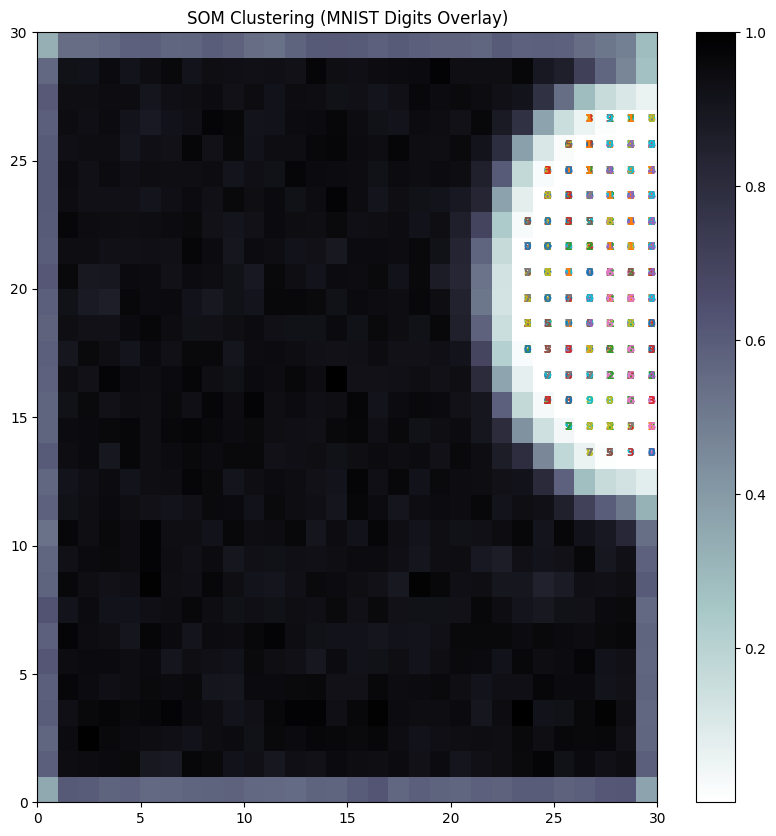

In [ ]:
def train_and_cluster():
    # Load MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

    # Initialize model and optimizer
    model = CNNLSTM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Step 1: Train CNN-LSTM (unsupervised)
    print("Training CNN-LSTM...")
    model.train()
    for epoch in range(15):
        for batch, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/10"):
            batch = batch.to(device)
            optimizer.zero_grad()
            features = model(batch)
            reconstruction = model.decoder(features)
            loss = F.mse_loss(reconstruction, batch) + 0.01*features.pow(2).mean()  # Need to add decoder



            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()


    # Step 2: Extract features
    print("Extracting features...")
    model.eval()
    features = []
    true_labels = []
    with torch.no_grad():
        for batch, labels in tqdm(train_loader):
            batch = batch.to(device)
            feats = model(batch)
            features.append(feats.cpu().numpy())
            true_labels.append(labels.numpy())
    features = np.concatenate(features)
    true_labels = np.concatenate(true_labels)

    # Step 3: Train SOM
    print("Clustering with SOM...")
    som = MiniSom(
        x=30, y=30,          # 10x10 grid (adjust based on expected clusters)
        input_len=64,        # Must match CNN-LSTM output dimension (64)
        sigma=1.5,           # Neighborhood radius
        learning_rate=0.2,
        neighborhood_function='gaussian',
        random_seed=42
    )
    som.train_random(features, 10000)  # 1000 iterations

    # Assign pseudo-labels based on SOM winner neurons
    winner_coords = np.array([som.winner(x) for x in features])
    pseudo_labels = winner_coords[:, 0] * 10 + winner_coords[:, 1]  # Flatten grid to 1D labels

    # Step 4: Evaluate clustering (NMI)
    nmi = nmi_score(true_labels, pseudo_labels)
    print(f"Clustering NMI: {nmi:.4f}")

    # Step 5: Visualize SOM
    plt.figure(figsize=(10, 10))
    plt.pcolor(som.distance_map().T, cmap='bone_r')  # U-matrix
    plt.colorbar()
    for i, (x, y) in enumerate([som.winner(f) for f in features[:1000]]):  # Plot 1000 samples
        plt.text(x + 0.5, y + 0.5, str(true_labels[i]),
                color=plt.cm.tab10(true_labels[i] / 10),
                fontdict={'weight': 'bold', 'size': 8})
    plt.title("SOM Clustering (MNIST Digits Overlay)")
    plt.show()

if __name__ == "__main__":
    train_and_cluster()

# K-means

Training CNN-LSTM...


Epoch 15/10: 100%|██████████| 235/235 [00:12<00:00, 19.12it/s]


Extracting features...


100%|██████████| 235/235 [00:12<00:00, 18.76it/s]


Clustering with K-means...
K-means NMI: 0.1935


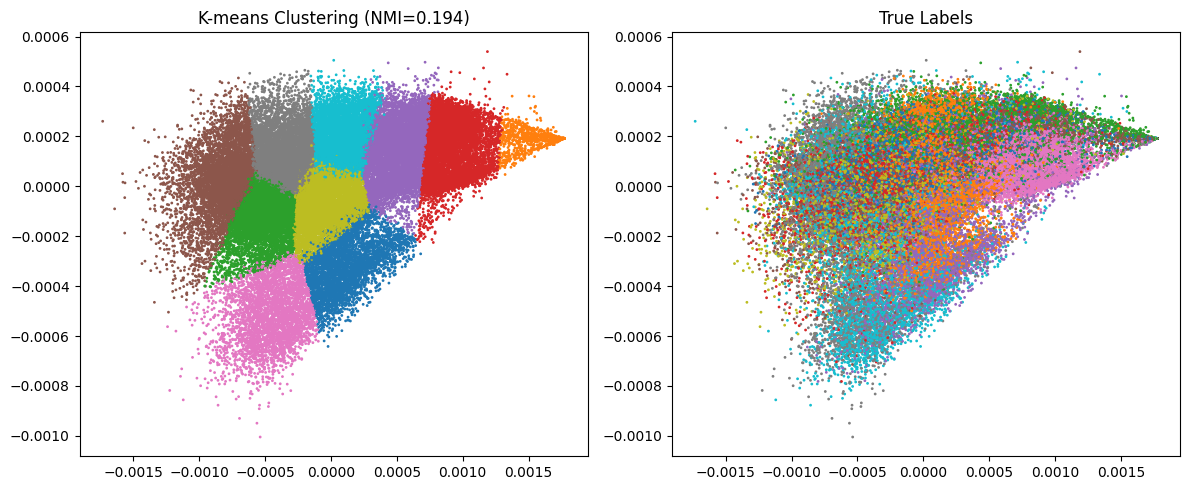

In [ ]:
def train_and_cluster():
    # Load MNIST
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

    # Initialize model and optimizer
    model = CNNLSTM().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Step 1: Train CNN-LSTM (unsupervised)
    print("Training CNN-LSTM...")
    model.train()
    for epoch in range(15):
        for batch, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/10"):
            batch = batch.to(device)
            optimizer.zero_grad()
            features = model(batch)
            reconstruction = model.decoder(features)
            loss = F.mse_loss(reconstruction, batch) + 0.01*features.pow(2).mean()  # Need to add decoder



            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()


    # Step 2: Extract features
    print("Extracting features...")
    model.eval()
    features = []
    true_labels = []
    with torch.no_grad():
        for batch, labels in tqdm(train_loader):
            batch = batch.to(device)
            feats = model(batch)
            features.append(feats.cpu().numpy())
            true_labels.append(labels.numpy())
    features = np.concatenate(features)
    true_labels = np.concatenate(true_labels)

    # Step 3: Apply K-means clustering (instead of SOM)
    print("Clustering with K-means...")
    kmeans = KMeans(n_clusters=10, n_init=20, random_state=42)
    kmeans_labels = kmeans.fit_predict(features)

    # Step 4: Evaluate clustering (NMI)
    kmeans_nmi = nmi_score(true_labels, kmeans_labels)
    print(f"K-means NMI: {kmeans_nmi:.4f}")

    # Step 5: Visualize results
    plt.figure(figsize=(12, 5))

    # PCA for visualization
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)

    # K-means visualization
    plt.subplot(121)
    plt.scatter(features_2d[:, 0], features_2d[:, 1], c=kmeans_labels, cmap='tab10', s=1)
    plt.title(f'K-means Clustering (NMI={kmeans_nmi:.3f})')

    # True labels visualization
    plt.subplot(122)
    plt.scatter(features_2d[:, 0], features_2d[:, 1], c=true_labels, cmap='tab10', s=1)
    plt.title('True Labels')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    train_and_cluster()

# COMPARISON

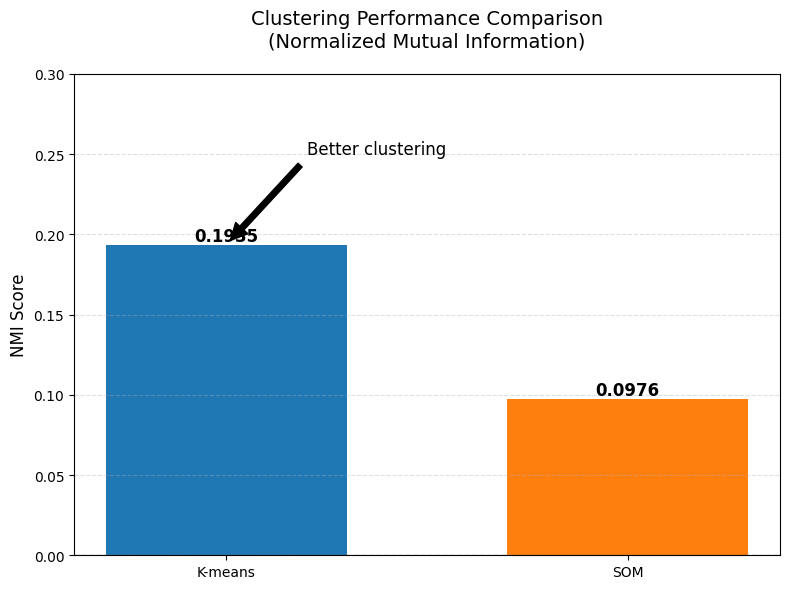

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your obtained NMI scores
kmeans_nmi = 0.1935
som_nmi = 0.0976

# Data for plotting
methods = ['K-means', 'SOM']
nmi_scores = [kmeans_nmi, som_nmi]
colors = ['#1f77b4', '#ff7f0e']  # Blue and orange

# Create figure
plt.figure(figsize=(8, 6), dpi=100)

# Create bars
bars = plt.bar(methods, nmi_scores, color=colors, width=0.6)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom',
             fontsize=12, fontweight='bold')

# Add horizontal line at random baseline (0) and perfect score (1)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.axhline(y=1, color='green', linestyle=':', linewidth=1, alpha=0.5)

# Chart formatting
plt.title('Clustering Performance Comparison\n(Normalized Mutual Information)',
          fontsize=14, pad=20)
plt.ylabel('NMI Score', fontsize=12)
plt.ylim(0, 0.3)  # Adjusted to show your values clearly
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate the better performing method
plt.annotate('Better clustering',
             xy=(0, kmeans_nmi), xytext=(0.2, 0.25),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)

plt.tight_layout()
plt.show()

# Clustering Algorithm

Explained variance ratio: 0.82

Clustering Results:
- Silhouette Score: 0.085
- Adjusted Rand Index: 0.360


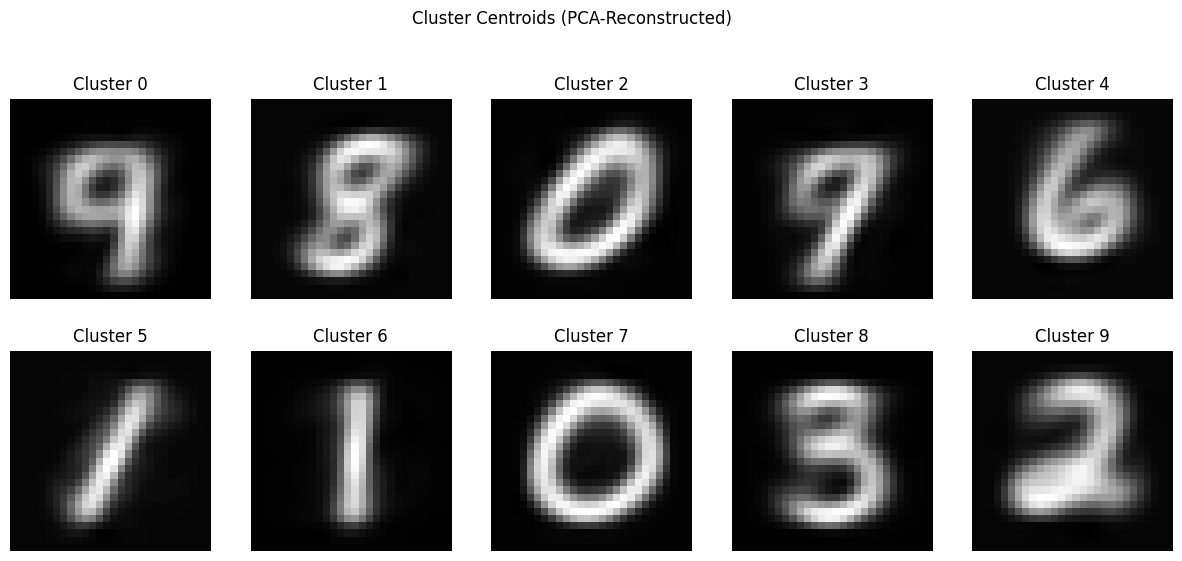

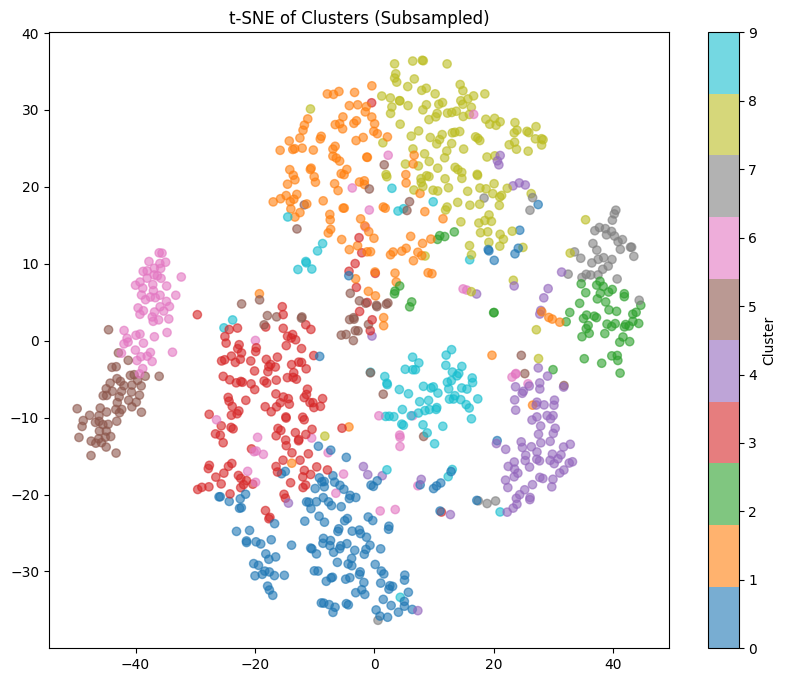

In [ ]:
# =============================================
# Clustering MNIST with PCA + K-Means (Option 1)
# =============================================

# Import additional required libraries
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Load and Prepare MNIST Data
# ------------------------------
# (Reusing your existing transform and dataset)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST (using same data as your original notebook)
mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Convert to numpy arrays and flatten
X = mnist_data.data.numpy()  # Shape: (60000, 28, 28)
X = X.reshape(len(X), -1)     # Flatten to (60000, 784)
y = mnist_data.targets.numpy()  # True labels (for evaluation)

# Normalize pixel values to [0, 1]
X = X / 255.0

# 2. Dimensionality Reduction with PCA
# -----------------------------------
# Reduce to 50 principal components (balances speed and info retention)
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X)

print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")

# 3. Apply K-Means Clustering
# --------------------------
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# 4. Evaluation Metrics
# ---------------------
# Silhouette Score (higher is better, range [-1, 1])
silhouette = silhouette_score(X_pca, clusters)

# Adjusted Rand Index (compares with true labels, 1=perfect match)
ari = adjusted_rand_score(y, clusters)

print(f"\nClustering Results:")
print(f"- Silhouette Score: {silhouette:.3f}")
print(f"- Adjusted Rand Index: {ari:.3f}")

# 5. Visualize Cluster Centroids
# -----------------------------
# Get PCA-reconstructed centroids
centroids_pca = kmeans.cluster_centers_
centroids = pca.inverse_transform(centroids_pca)  # Back to original space

# Plot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(centroids[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Cluster {i}")
    ax.axis('off')
plt.suptitle('Cluster Centroids (PCA-Reconstructed)', y=1.02)
plt.show()

# 6. Optional: t-SNE Visualization (for intuition)
# -----------------------------------------------
# (This part is slower but helpful for understanding)
from sklearn.manifold import TSNE

# Subsample for faster t-SNE
sample_idx = np.random.choice(len(X_pca), 1000, replace=False)
X_sample = X_pca[sample_idx]
y_sample = y[sample_idx]
c_sample = clusters[sample_idx]

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=c_sample, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('t-SNE of Clusters (Subsampled)')
plt.show()

In [ ]:
clusters = kmeans.fit_predict(X_pca)  # predicted cluster labels
y = mnist_data.targets.numpy()        # true digit labels


In [ ]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
nmi = normalized_mutual_info_score(y, clusters)
print(f"- Normalized Mutual Information (NMI): {nmi:.3f}")

- Normalized Mutual Information (NMI): 0.490


Customized k-means

# Initialize Model, Loss Function, and Optimizer

In [ ]:
class MyMLP ( nn . Module ) :
  def __init__ ( self , input_size , hidden_size , output_size ) :
    super ( MyMLP , self ) . __init__ ()
    self . net = nn . Sequential (
    nn . Linear ( input_size , hidden_size ) ,
    nn . ReLU () ,
    nn . Linear ( hidden_size , output_size )
    )

  def forward ( self , x ) :
    return self . net ( x )

In [ ]:
input_size = 784 # 28 x28 images flattened
hidden_size = 128
output_size = 10 # Number of classes in MNIST
learning_rate = 0.001
batch_size = 64
epochs = 5


In [ ]:
device = torch . device ("cuda" if torch . cuda . is_available () else "cpu")
model = MyMLP ( input_size , hidden_size , output_size ) . to ( device )

In [ ]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,}")
    return total, trainable

count_parameters(model)


Total parameters: 101,770
Trainable parameters: 101,770


(101770, 101770)

In [ ]:
device = torch . device ("cuda" if torch . cuda . is_available () else "cpu")
model = MyMLP ( input_size , hidden_size , output_size ) . to ( device )
criterion = nn . CrossEntropyLoss ()
optimizer = optim . Adam ( model . parameters () , lr = learning_rate )


In [ ]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,}")
    return total, trainable

# Instantiate and count
model = CNNLSTM().to(device)
count_parameters(model)

# Training Loop



In [ ]:
for epoch in range ( epochs ) :
    model . train ()
    for batch_idx , ( data , targets ) in enumerate ( train_loader ) :
        data = data . view ( data . size (0) , -1) . to ( device )
        targets = targets . to ( device )
        scores = model ( data )
        loss = criterion ( scores , targets )
        optimizer . zero_grad ()
        loss . backward ()
        optimizer . step ()
    print ( f" Epoch [{ epoch +1}/{ epochs }] , Loss : { loss . item () :.4f}")


 Epoch [1/5] , Loss : 0.2051
 Epoch [2/5] , Loss : 0.2057
 Epoch [3/5] , Loss : 0.0238
 Epoch [4/5] , Loss : 0.1084
 Epoch [5/5] , Loss : 0.0604


# Evaluation

In [ ]:
model . eval ()
correct = 0
total = 0
with torch . no_grad () :
   for data , targets in test_loader :
        data = data . view ( data . size (0) , -1) . to ( device )
        targets = targets . to ( device )
        outputs = model ( data )
        _ , predicted = torch .max ( outputs . data , 1)
        total += targets . size (0)
        correct += ( predicted == targets ) .sum () . item ()

print ( f" Test Accuracy : {100 * correct / total :.2f}%")


 Test Accuracy : 96.67%


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import adjusted_rand_score

# 1. Extract features from the hidden layer
def extract_hidden_features(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in loader:
            data = data.view(data.size(0), -1).to(device)
            out = model.net[0](data)  # First Linear layer output
            out = F.relu(out)         # Apply ReLU (same as model.net[1])
            features.append(out)
            labels.append(target)
    return torch.cat(features), torch.cat(labels)

# 2. Initialize k random centroids
def init_centroids(X, k):
    indices = torch.randperm(X.size(0))[:k]
    return X[indices]

# 3. Cosine similarity
def cosine_similarity(X, centroids):
    X_norm = X / X.norm(dim=1, keepdim=True)
    C_norm = centroids / centroids.norm(dim=1, keepdim=True)
    return torch.mm(X_norm, C_norm.T)

# 4. Assign clusters using cosine similarity
def assign_clusters_cosine(X, centroids):
    sims = cosine_similarity(X, centroids)
    return torch.argmax(sims, dim=1)

# 5. Update centroids
def update_centroids(X, cluster_assignments, k):
    new_centroids = []
    for i in range(k):
        cluster_points = X[cluster_assignments == i]
        if len(cluster_points) == 0:
            new_centroids.append(X[torch.randint(0, X.size(0), (1,))])
        else:
            new_centroids.append(cluster_points.mean(dim=0))
    return torch.stack(new_centroids)

# 6. Full K-Means loop with cosine
def custom_kmeans(X, k=10, max_iters=100, tol=1e-4):
    centroids = init_centroids(X, k)
    for i in range(max_iters):
        cluster_assignments = assign_clusters_cosine(X, centroids)
        new_centroids = update_centroids(X, cluster_assignments, k)
        if torch.norm(centroids - new_centroids) < tol:
            break
        centroids = new_centroids
    return cluster_assignments, centroids

# === Run Everything ===

# Extract hidden layer features
X, y_true = extract_hidden_features(model, test_loader)
X = X.to(device)

# Cluster using custom cosine-similarity KMeans
k = 10
cluster_labels, centroids = custom_kmeans(X, k=k)

# Show sample cluster assignments
print("Sample cluster assignments:", cluster_labels[:20].tolist())

# Evaluate clustering quality (optional)
print(f"Adjusted Rand Index vs true labels: {adjusted_rand_score(y_true.cpu(), cluster_labels.cpu()):.4f}")


Sample cluster assignments: [1, 8, 5, 6, 3, 5, 2, 2, 7, 2, 6, 7, 2, 6, 5, 0, 3, 1, 0, 3]
Adjusted Rand Index vs true labels: 0.6791


In [ ]:
nmi = normalized_mutual_info_score(y_true.cpu(), cluster_labels.cpu())
print(f"- Normalized Mutual Information (NMI): {nmi:.3f}")

- Normalized Mutual Information (NMI): 0.721


<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

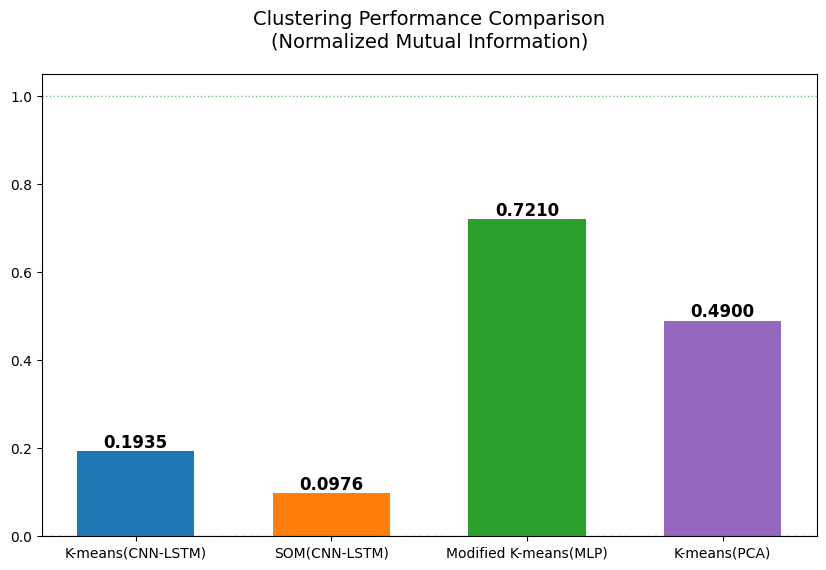

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your obtained NMI scores
kmeans_nmi = 0.1935
som_nmi = 0.0976
modified_kmeans_nmi = 0.721
kmeans_pca = 0.490

# Data for plotting
methods = ['K-means(CNN-LSTM)', 'SOM(CNN-LSTM)', 'Modified K-means(MLP)', 'K-means(PCA)']
nmi_scores = [kmeans_nmi, som_nmi, modified_kmeans_nmi, kmeans_pca]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']  # Blue, Orange, Green, Purple

# Create figure
plt.figure(figsize=(10, 6), dpi=100)  # Wider figure for 4 bars

# Create bars
bars = plt.bar(methods, nmi_scores, color=colors, width=0.6)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom',
             fontsize=12, fontweight='bold')

# Add horizontal line at random baseline (0) and perfect score (1)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.axhline(y=1, color='green', linestyle=':', linewidth=1, alpha=0.5)

# Chart formatting
plt.title('Clustering Performance Comparison\n(Normalized Mutual Information)',
          fontsize=14, pad=20)
plt.ylabel

# **EXPERIMENTATION (Extra)**

# Deep Clustering

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from tqdm import tqdm

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256

# Your dataset loading code (slightly enhanced)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Using your normalization values
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:

# CNN Model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU()
        )
        self.classifier = nn.Linear(128, 10)  # 10 clusters for MNIST

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features), features

# DeepCluster Implementation
class DeepCluster:
    def __init__(self):
        self.model = ConvNet().to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.kmeans = KMeans(n_clusters=10, n_init=20)

    def extract_features(self, loader):
        self.model.eval()
        features = []

        with torch.no_grad():
            for images, _ in tqdm(loader, desc='Extracting features'):
                images = images.to(device)
                _, feats = self.model(images)
                features.append(feats)

        features = torch.cat(features)
        features = F.normalize(features, dim=1)  # Normalize here
        return features.cpu().numpy()
       # return torch.cat(features).numpy()

    def cluster(self, epochs=12, clustering_freq=4):
        true_labels = train_dataset.targets.numpy()

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")

            # Cluster every 'clustering_freq' epochs
            if epoch % clustering_freq == 0 or epoch == 0:
                features = self.extract_features(train_loader)
                #######################################
                # features = torch.from_numpy(features).float().to(device)
                # features = F.normalize(features, dim=1)
                # features = features.cpu().numpy()  # Normalize!
                #################################
                self.kmeans.fit(features)
                pseudo_labels = self.kmeans.labels_
                nmi = nmi_score(true_labels, pseudo_labels)
                print(f'Clustering NMI: {nmi:.4f}')

            # Train with pseudo-labels
            self.train_with_pseudo_labels(pseudo_labels)

    def train_with_pseudo_labels(self, pseudo_labels):
        self.model.train()
        total_loss = 0
        label_idx = 0

        for images, _ in tqdm(train_loader, desc='Training'):
            images = images.to(device)
            batch_labels = torch.from_numpy(
                pseudo_labels[label_idx:label_idx+len(images)]
            ).long().to(device)  # Convert to torch.long

            self.optimizer.zero_grad()
            outputs, _ = self.model(images)
            loss = F.cross_entropy(outputs, batch_labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            label_idx += len(images)

        print(f'Train Loss: {total_loss/len(train_loader):.4f}')

# Run DeepCluster
deepcluster = DeepCluster()
deepcluster.cluster(epochs=12, clustering_freq=4)

# Final Evaluation
final_features = deepcluster.extract_features(test_loader)
final_clusters = deepcluster.kmeans.predict(final_features)
true_test_labels = test_dataset.targets.numpy()
final_nmi = nmi_score(true_test_labels, final_clusters)
print(f'\nFinal Test NMI: {final_nmi:.4f}')


Epoch 1/12


Extracting features: 100%|██████████| 235/235 [00:11<00:00, 20.67it/s]


Clustering NMI: 0.0003


Training: 100%|██████████| 235/235 [00:13<00:00, 17.82it/s]


Train Loss: 2.2889

Epoch 2/12


Training: 100%|██████████| 235/235 [00:13<00:00, 17.87it/s]


Train Loss: 2.2877

Epoch 3/12


Training: 100%|██████████| 235/235 [00:13<00:00, 17.04it/s]


Train Loss: 2.2874

Epoch 4/12


Training: 100%|██████████| 235/235 [00:13<00:00, 17.35it/s]


Train Loss: 2.2873

Epoch 5/12


Extracting features: 100%|██████████| 235/235 [00:11<00:00, 21.19it/s]


Clustering NMI: 0.0003


Training: 100%|██████████| 235/235 [00:13<00:00, 17.73it/s]


Train Loss: 2.2838

Epoch 6/12


Training: 100%|██████████| 235/235 [00:13<00:00, 17.34it/s]


Train Loss: 2.2801

Epoch 7/12


Training: 100%|██████████| 235/235 [00:13<00:00, 17.65it/s]


Train Loss: 2.2801

Epoch 8/12


Training: 100%|██████████| 235/235 [00:15<00:00, 15.59it/s]


Train Loss: 2.2801

Epoch 9/12


Extracting features: 100%|██████████| 235/235 [00:11<00:00, 20.65it/s]


Clustering NMI: 0.0002


Training: 100%|██████████| 235/235 [00:14<00:00, 16.13it/s]


Train Loss: 1.9761

Epoch 10/12


Training: 100%|██████████| 235/235 [00:13<00:00, 17.43it/s]


Train Loss: 1.9497

Epoch 11/12


Training: 100%|██████████| 235/235 [00:13<00:00, 17.06it/s]


Train Loss: 1.9494

Epoch 12/12


Training: 100%|██████████| 235/235 [00:13<00:00, 17.31it/s]


Train Loss: 1.9492


Extracting features: 100%|██████████| 40/40 [00:01<00:00, 22.05it/s]


Final Test NMI: 0.0000


Pretraining Epoch 1: 100%|██████████| 235/235 [00:22<00:00, 10.35it/s]


Pretrain Loss: 1.9021


Pretraining Epoch 2: 100%|██████████| 235/235 [00:23<00:00, 10.11it/s]


Pretrain Loss: 1.1375


Pretraining Epoch 3: 100%|██████████| 235/235 [00:22<00:00, 10.49it/s]


Pretrain Loss: 0.8104


Pretraining Epoch 4: 100%|██████████| 235/235 [00:22<00:00, 10.51it/s]


Pretrain Loss: 0.6658


Pretraining Epoch 5: 100%|██████████| 235/235 [00:22<00:00, 10.43it/s]


Pretrain Loss: 0.5913

Epoch 1/12


Extracting features: 100%|██████████| 235/235 [00:14<00:00, 15.84it/s]


Clustering NMI: 0.0003


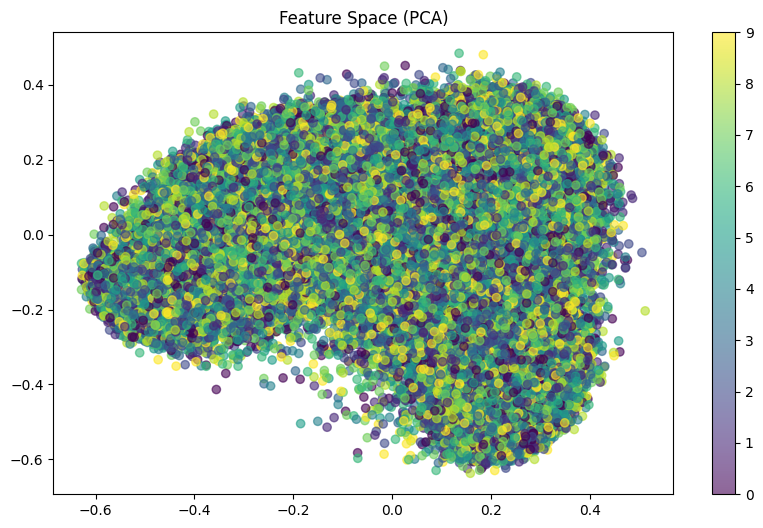

Training: 100%|██████████| 235/235 [00:23<00:00,  9.96it/s]


Train Loss: 3.3170

Epoch 2/12


Training: 100%|██████████| 235/235 [00:23<00:00, 10.06it/s]


Train Loss: 2.4219

Epoch 3/12


Training: 100%|██████████| 235/235 [00:23<00:00, 10.12it/s]


Train Loss: 2.3510

Epoch 4/12


Training: 100%|██████████| 235/235 [00:22<00:00, 10.24it/s]


Train Loss: 2.3272

Epoch 5/12


Extracting features: 100%|██████████| 235/235 [00:15<00:00, 15.57it/s]


Clustering NMI: 0.0004


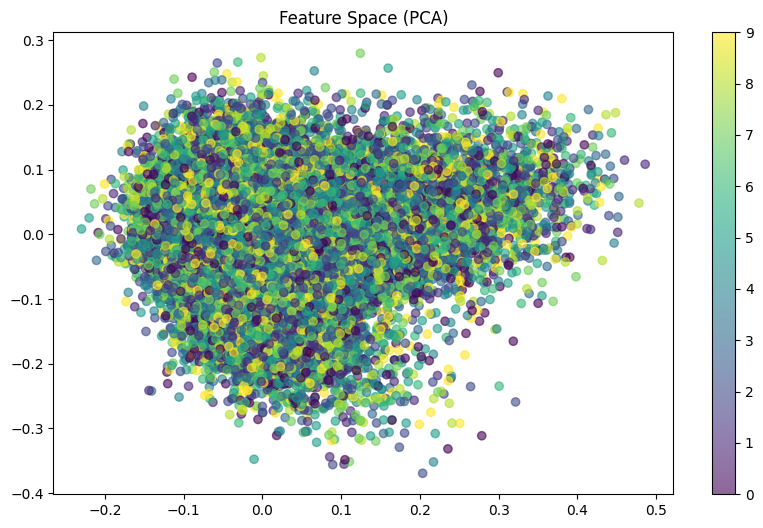

Training: 100%|██████████| 235/235 [00:23<00:00,  9.88it/s]


Train Loss: 2.3139

Epoch 6/12


Training: 100%|██████████| 235/235 [00:24<00:00,  9.48it/s]


Train Loss: 2.3065

Epoch 7/12


Training: 100%|██████████| 235/235 [00:25<00:00,  9.21it/s]


Train Loss: 2.3036

Epoch 8/12


Training: 100%|██████████| 235/235 [00:25<00:00,  9.23it/s]


Train Loss: 2.3012

Epoch 9/12


Extracting features: 100%|██████████| 235/235 [00:15<00:00, 14.91it/s]


Clustering NMI: 0.0003


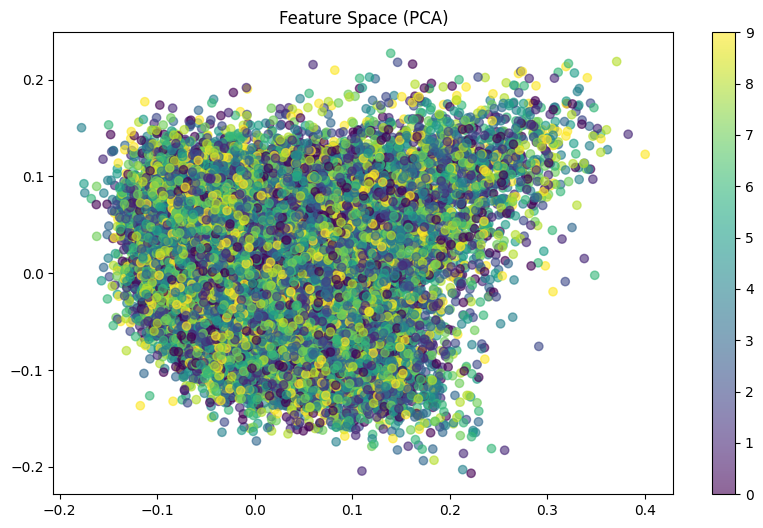

Training:  27%|██▋       | 64/235 [00:07<00:19,  8.85it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16_bn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchvision.transforms import Resize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# VGG-based Model
class VGGDeepCluster(nn.Module):
    def __init__(self):
        super(VGGDeepCluster, self).__init__()
        # Load pretrained VGG16 with BatchNorm
        self.vgg = vgg16_bn(pretrained=True)
        # Modify first layer for MNIST (1 channel instead of 3)
        original_first_layer = self.vgg.features[0]
        self.vgg.features[0] = nn.Conv2d(1, 64,
                                       kernel_size=original_first_layer.kernel_size,
                                       stride=original_first_layer.stride,
                                       padding=original_first_layer.padding,
                                       bias=original_first_layer.bias is not None)
        # Remove classifier, keep features
        self.features = self.vgg.features
        # Add custom head for clustering
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        self.classifier = nn.Linear(128, 10)  # 10 clusters for MNIST

    def forward(self, x):
        x = self.features(x)
        x = self.fc(x)
        return self.classifier(x), x

# DeepCluster Implementation
class DeepCluster:
    def __init__(self):
        self.model = VGGDeepCluster().to(device)
        # Only optimize the custom layers (not pretrained features)
        self.optimizer = torch.optim.Adam([
            {'params': self.model.fc.parameters()},
            {'params': self.model.classifier.parameters()}
        ], lr=0.0001)
        self.kmeans = KMeans(n_clusters=10, n_init=50, max_iter=500, random_state=42)

    def extract_features(self, loader):
        self.model.eval()
        features = []
        with torch.no_grad():
            for images, _ in tqdm(loader, desc='Extracting features'):
                images = images.to(device)
                _, feats = self.model(images)
                features.append(feats)
        features = torch.cat(features)
        features = F.normalize(features, dim=1)  # Critical: L2 normalization
        return features.cpu().numpy()

    def pretrain(self, loader, epochs=5):
        self.model.train()
        # Freeze feature extractor during pretraining
        for param in self.model.features.parameters():
            param.requires_grad = False

        for epoch in range(epochs):
            total_loss = 0
            for images, labels in tqdm(loader, desc=f'Pretraining Epoch {epoch+1}'):
                images, labels = images.to(device), labels.to(device)
                self.optimizer.zero_grad()
                outputs, _ = self.model(images)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            print(f'Pretrain Loss: {total_loss/len(loader):.4f}')

    def cluster(self, train_loader, epochs=30, clustering_freq=5):
        true_labels = train_loader.dataset.targets.numpy()

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")

            # Cluster every 'clustering_freq' epochs
            if epoch % clustering_freq == 0 or epoch == 0:
                features = self.extract_features(train_loader)
                self.kmeans.fit(features)
                pseudo_labels = self.kmeans.labels_
                nmi = nmi_score(true_labels, pseudo_labels)
                print(f'Clustering NMI: {nmi:.4f}')

                # Visualize features (optional)
                self.visualize_features(features, true_labels)

            # Train with pseudo-labels
            self.train_with_pseudo_labels(train_loader, pseudo_labels)

    def train_with_pseudo_labels(self, loader, pseudo_labels):
        self.model.train()
        total_loss = 0
        label_idx = 0

        for images, _ in tqdm(loader, desc='Training'):
            images = images.to(device)
            batch_labels = torch.from_numpy(
                pseudo_labels[label_idx:label_idx+len(images)]
            ).long().to(device)

            self.optimizer.zero_grad()
            outputs, _ = self.model(images)
            loss = F.cross_entropy(outputs, batch_labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            label_idx += len(images)

        print(f'Train Loss: {total_loss/len(loader):.4f}')

    def visualize_features(self, features, true_labels):
        pca = PCA(n_components=2)
        feats_2d = pca.fit_transform(features)
        plt.figure(figsize=(10, 6))
        plt.scatter(feats_2d[:, 0], feats_2d[:, 1], c=true_labels, alpha=0.6)
        plt.title("Feature Space (PCA)")
        plt.colorbar()
        plt.show()

# Usage Example
if __name__ == "__main__":
    from torchvision.datasets import MNIST
    from torchvision.transforms import ToTensor, Grayscale, Normalize, Compose
    from torch.utils.data import DataLoader

    # Define transforms - important for pretrained models
    transform = Compose([
        Grayscale(num_output_channels=1),
        Resize((32, 32)),# MNIST is grayscale but needs explicit conversion
        ToTensor(),
        Normalize(mean=[0.5], std=[0.5])  # Normalize to match pretrained stats
    ])

    # Load MNIST
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    # Run DeepCluster
    deepcluster = DeepCluster()
    deepcluster.pretrain(train_loader, epochs=5)  # Warm-up with real labels
    deepcluster.cluster(train_loader, epochs=12, clustering_freq=4)

    # Final Evaluation
    final_features = deepcluster.extract_features(test_loader)
    final_clusters = deepcluster.kmeans.predict(final_features)
    true_test_labels = test_dataset.targets.numpy()
    final_nmi = nmi_score(true_test_labels, final_clusters)
    print(f'\nFinal Test NMI: {final_nmi:.4f}')